In [2]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
#Use '%pylab' for interactive plots
%pylab inline 
import shapefile

Populating the interactive namespace from numpy and matplotlib


In [4]:
#Load the Gechemical data: Latitude=5, Longitude=6, Age=9, CopperAmount=142
filename = 'data/EarthQuery.txt'
#filename = '/Users/nbutter/Geodata/Geochem/NBQuery/copper.txt'
chemdata=pd.read_csv(filename, sep='\t', skipinitialspace=True)
chemdata.shape

/Users/nbutter/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,4,13,14,15,16,17,20,21,23,25,29,31,33,35,36,37,39,40,41,42,43,44,45,47,48,49,50,51,53,55,56,57,58,59,61,62,63,64,65,67,71,73,74,75,76,77,79,80,81,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,103,104,105,106,107,108,109,110,111,113,114,115,116,117,118,119,121,123,125,126,127,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,155,156,157,159,160,161,163,165,167,170,171,173,175,176,177,179,180,181,183,184,185,187,189,190,191,195,197,198,199,201,202,203,205,206,207,211,213,215,216,217,218,219,223,224,225,227,229,231,232,233,234,235,236,237,238,239,241,243,245,247,250,251,255,257,258,259,261,263,265,267,269,271,272,273,275,277,279,281,283,284,285,286,287,288,289,291,293,295,297,298,299,301,302,303,307,309,310,311,312,313,314,315) have mixed types. Specify dtype option on import or set low_memory=False.
  interacti

(467841, 320)

In [5]:
#Drop Empty columns
chemdata = chemdata.dropna(axis=1, how='all')
chemdata.shape

(467841, 300)

In [6]:
#From Dan Steinberg's 'wrangle.py'
# Units -----------------------------------------------------------------------

# Remove "UNITS" columns and remove white space -- Check units are consistent
dropcols = []
stripcols = []
unitrecord = {}

for i, cname in enumerate(chemdata.columns):
    if cname.find("UNIT") > 0:

        # Filter NaN values
        nanmask = ~pd.isnull(chemdata[cname])

        # Change "less than" values (no-detect) to 0
        dcol = chemdata.columns[i-1]
        ltmask = [str(row).find('<') >= 0 for row in chemdata[dcol]]
        chemdata[dcol][np.array(ltmask)] = 0

        # Now convert all units to floats
        chemdata[dcol] = chemdata[dcol].astype(float)

        # Get the set of units
        setunits = set(chemdata[cname][nanmask].values)

        # If the units are insconsistent in a column, deal with it or drop it
        if len(setunits) > 1:

            if (setunits == set(['WT%', 'PPM'])):
                wgtmask = chemdata[cname] == "WT%"
                chemdata[dcol][wgtmask] *= 1e4
                unitrecord.update({dcol: 'PPM'})
            elif (setunits == set(['PPB', 'PPM'])):
                ppmmask = chemdata[cname] == "PPM"
                chemdata[dcol][ppmmask] *= 1e3
                unitrecord.update({dcol: 'PPB'})
            elif (setunits == set(['WT%', 'PPB', 'PPM'])):
                ppmmask = chemdata[cname] == "PPM"
                wgtmask = chemdata[cname] == "WT%"
                chemdata[dcol][ppmmask] *= 1e3
                chemdata[dcol][wgtmask] *= 1e7
                unitrecord.update({dcol: 'PPB'})
            else:
                vals = nanmask.sum()
                print("Multiple units, {}, in {} cannot be converted, " \
                      "dropping {} values!".format(setunits, cname, vals))
                dropcols.append(dcol)
                stripcols.pop()
        else:
            unitrecord.update({dcol: setunits.pop()})

        # Add column name to drop list
        dropcols.append(cname)
        continue

    stripcols.append(chemdata.columns[i].strip())

chemdata = chemdata.drop(dropcols, 1)
chemdata.columns = stripcols
chemdata.shape

/Users/nbutter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nbutter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Multiple units, {'NG/G', 'PPM', 'DPM/G'}, in TH232 UNIT  cannot be converted, dropping 945 values!
Multiple units, {'PPM', 'DPM/G'}, in U238 UNIT  cannot be converted, dropping 933 values!
Multiple units, {'PPM', 'DPM/G'}, in PA231 UNIT  cannot be converted, dropping 497 values!


/Users/nbutter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nbutter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Multiple units, {'PPG', 'PPT', 'PPM'}, in OS UNIT  cannot be converted, dropping 2297 values!
Multiple units, {'PPG', 'PPT', 'PPM'}, in RE UNIT  cannot be converted, dropping 1567 values!
Multiple units, {'ATOMS PER GRAM', 'PPM'}, in BE10_BE UNIT  cannot be converted, dropping 309 values!


/Users/nbutter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Multiple units, {'PPG', 'PPB', 'PPM'}, in PT UNIT  cannot be converted, dropping 7867 values!
Multiple units, {'R/R(A)', 'RATIO'}, in HE3_HE4 UNIT  cannot be converted, dropping 294 values!
Multiple units, {'PPG', 'PPT', 'PPB', 'PPM'}, in IR UNIT  cannot be converted, dropping 4098 values!


(467841, 151)

In [7]:
# Ages ------------------------------------------------------------------------

# Remove samples without ages
chemdata = chemdata[~np.isnan(chemdata['AGE'].values)]

# Adjust samples with infeasible ages
chemdata['AGE'] = np.abs(chemdata['AGE'])
iagemask = chemdata['AGE'].values > 5.0e3
chemdata['AGE'][iagemask] /= 1.0e6

# Make sure the min and max ages are also adjusted if they exist
chemdata['MIN AGE'][iagemask & ~pd.isnull(chemdata['MIN AGE'])] /= 1.0e6
chemdata['MAX AGE'][iagemask & ~pd.isnull(chemdata['MAX AGE'])] /= 1.0e6

chemdata.shape

/Users/nbutter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/nbutter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/nbutter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


(467841, 151)

In [8]:
chemdata.columns.values

array(['SAMPLE ID', 'IGSN', 'SOURCE', 'REFERENCE', 'CRUISE ID',
       'LATITUDE', 'LONGITUDE', 'LOC PREC', 'MIN AGE', 'AGE', 'MAX AGE',
       'MATERIAL', 'TYPE', 'COMPOSITION', 'ROCK NAME', 'MINERAL', 'SIO2',
       'U234_U238', 'TIO2', 'AL2O3', 'FE2O3', 'TH230_TH232', 'FE2O3T',
       'TH232_TH230', 'FEO', 'FEOT', 'MGO', 'RA228_RA226', 'CAO', 'NA2O',
       'K2O', 'P2O5', 'MNO', 'U238_ACTIVITY', 'LOI', 'H2O_PLUS', 'TH230',
       'H2O_MINUS', 'H2O', 'RA226', 'CR2O3', 'NIO', 'LA', 'CE', 'CACO3',
       'PR', 'SM', 'EU', 'GD', 'TB', 'DY', 'HO', 'ER', 'TM', 'YB',
       'U234_U238_ACTIVITY', 'LU', 'LI', 'BE', 'B', 'C', 'CO2', 'F', 'CL',
       'K', 'CA', 'MG', 'SC', 'TI', 'V', 'FE', 'CR', 'MN', 'CO', 'NI',
       'CU', 'ZN', 'GA', 'ZR', 'GER', 'SR', 'K40_AR36', 'BI',
       'OS187_OS188', 'NB', 'TH232_U238', 'PB208_PB206', 'CD',
       'PO210_TH230', 'U238_PB204', 'BA', 'AR40_AR36', 'W', 'AR37_AR39',
       'AU', 'XE129_XE132', 'LU176_HF177', 'HG', 'OS186_OS188',
       'PB206_PB208', 

In [16]:
cudata=chemdata[['LATITUDE', 'LONGITUDE', 'AGE', 'CU']].values

In [17]:
print(cudata)

[[ 3.92667e+01 -1.15000e+02  1.11000e+02          nan]
 [ 3.92583e+01 -1.14992e+02  1.11000e+02          nan]
 [ 3.92667e+01 -1.15033e+02  1.11000e+02          nan]
 ...
 [-6.48620e+01 -6.42080e+01  1.25583e-02          nan]
 [-6.48620e+01 -6.42080e+01  1.25591e-02          nan]
 [-6.48620e+01 -6.42080e+01  1.25832e-02          nan]]


In [19]:
cudata=cudata[~np.isnan(cudata).any(axis=1)]

In [24]:
numpy.savetxt("EarthChemCU.txt",cudata,delimiter=',',fmt='%1.5f,%1.5f,%1.1f,%1.1f')

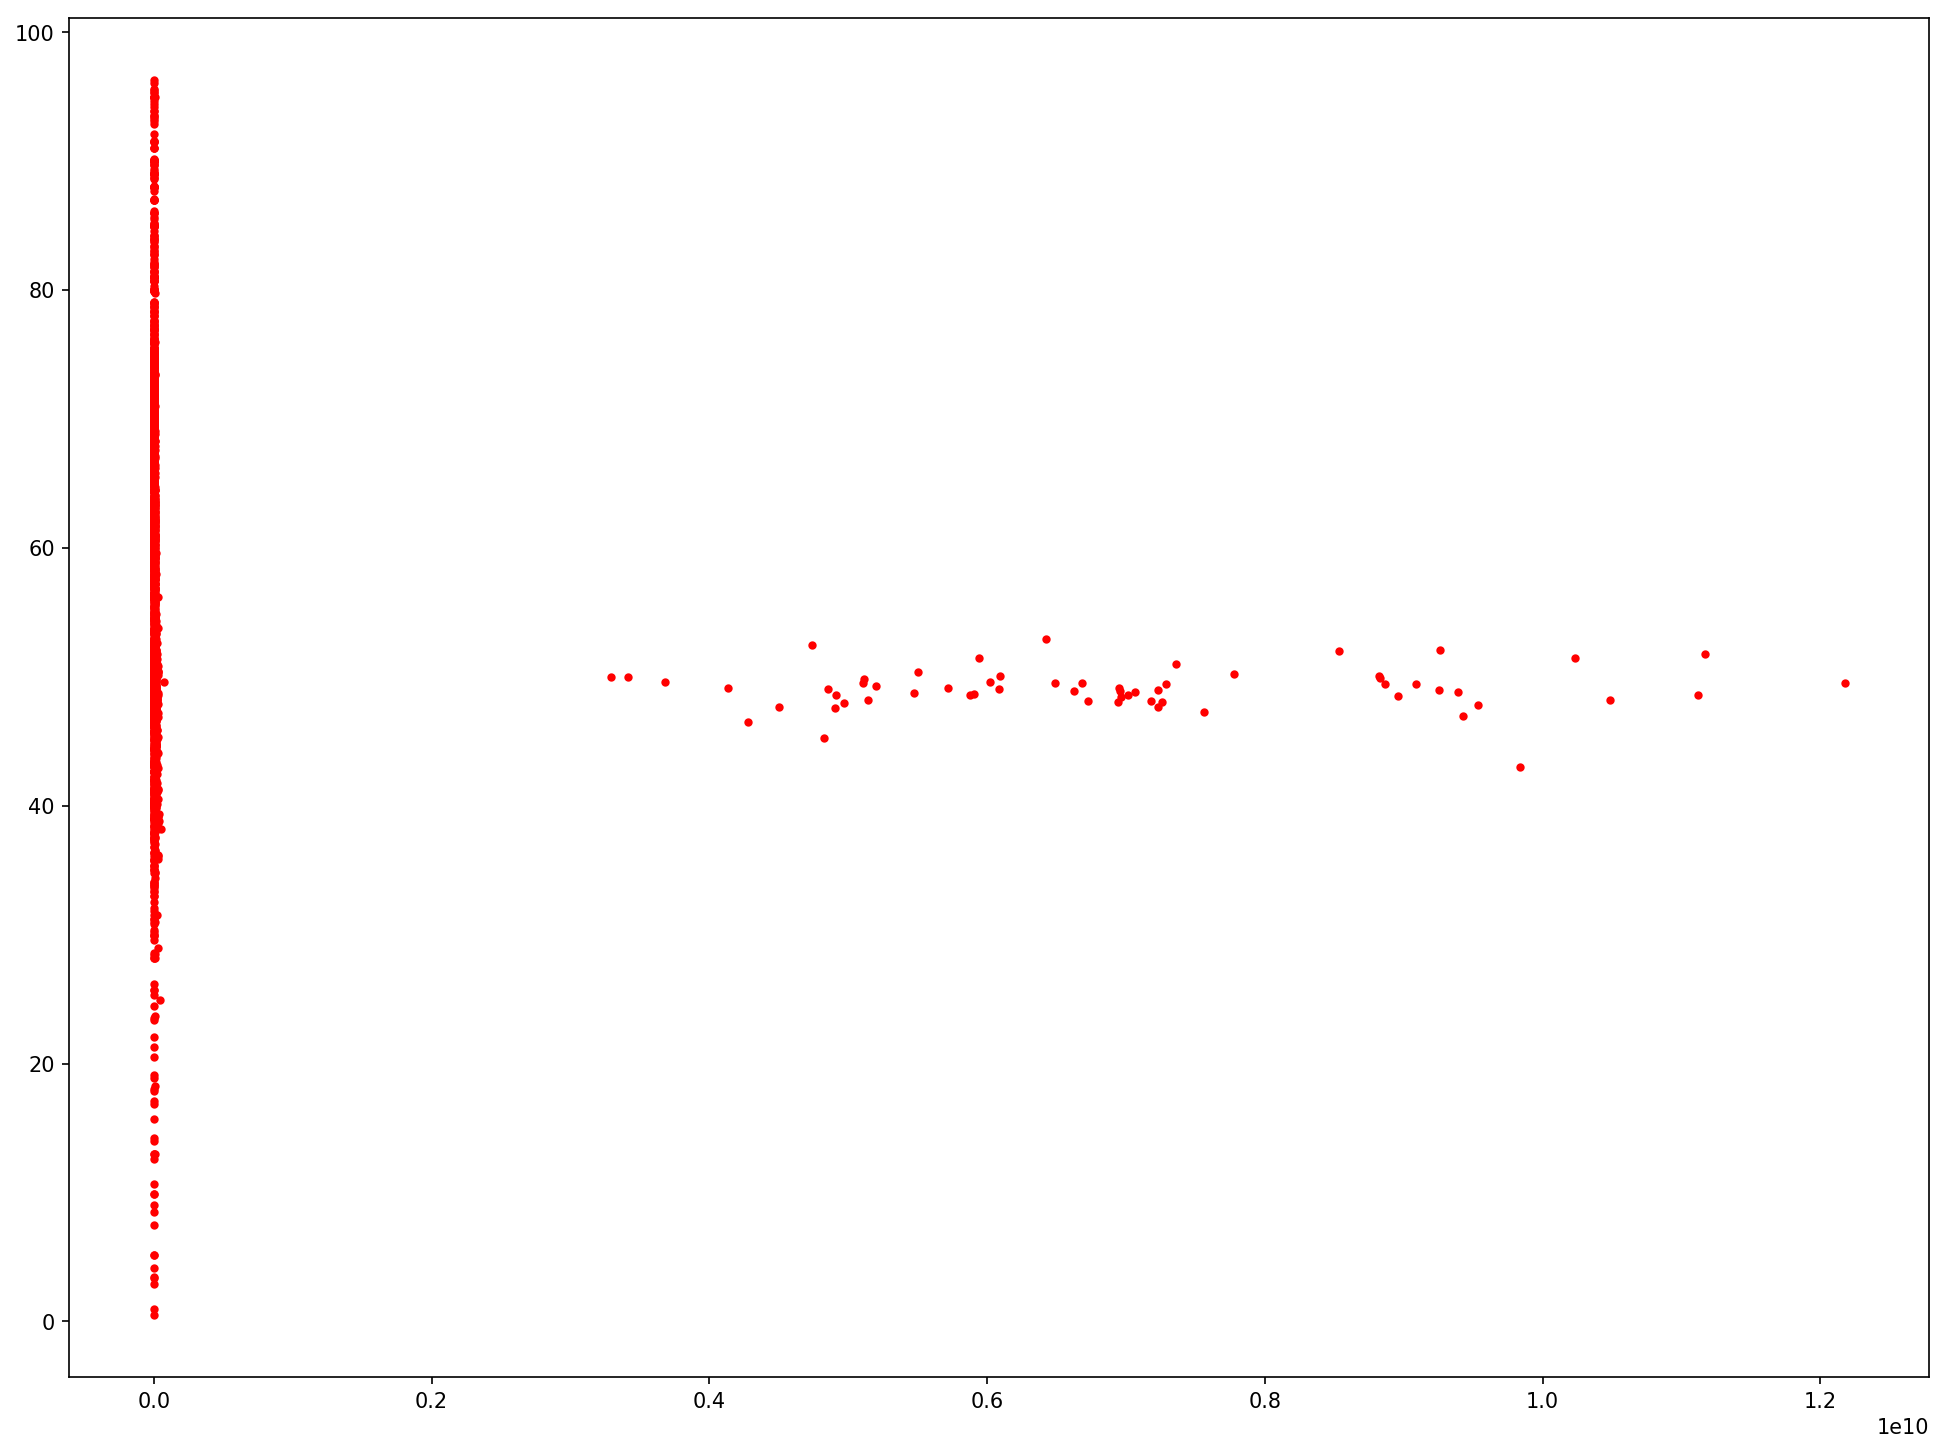

In [11]:
#Felsic to intermediate magmatic intrusions are associated with porphyrys
#So, A high SI02 should indicate this
plotdataX=chemdata[chemdata.CU > 200][['TI']].values
plotdataY=chemdata[chemdata.CU > 200][['SIO2']].values
#plotdataX=chemdata['CU'].values
#plotdataY=chemdata['SIO2'].values

fig = plt.figure(figsize=(16,12),dpi=150)
plt.plot(plotdataX,plotdataY,'r.')
plt.show()

In [13]:
chemdata[chemdata.CU > 200].values

array([['153', nan, 'NAVDAT', ..., nan, nan, nan],
       ['154', nan, 'NAVDAT', ..., nan, nan, nan],
       ['66L-98', nan, 'NAVDAT', ..., nan, nan, 2.7164200000000003],
       ..., 
       ['DSDP031-0295-002R-001/034-039', nan, 'SEDDB', ..., 96.8, 3.93,
        14.1054],
       ['DSDP034-0321-003R-006/024-030', nan, 'SEDDB', ..., 37.7, 11.9,
        10.825],
       ['ODP0181-1123C-029X-003/059-061', 'ODP02R1BY', 'SEDDB', ..., 11.1,
        nan, nan]], dtype=object)

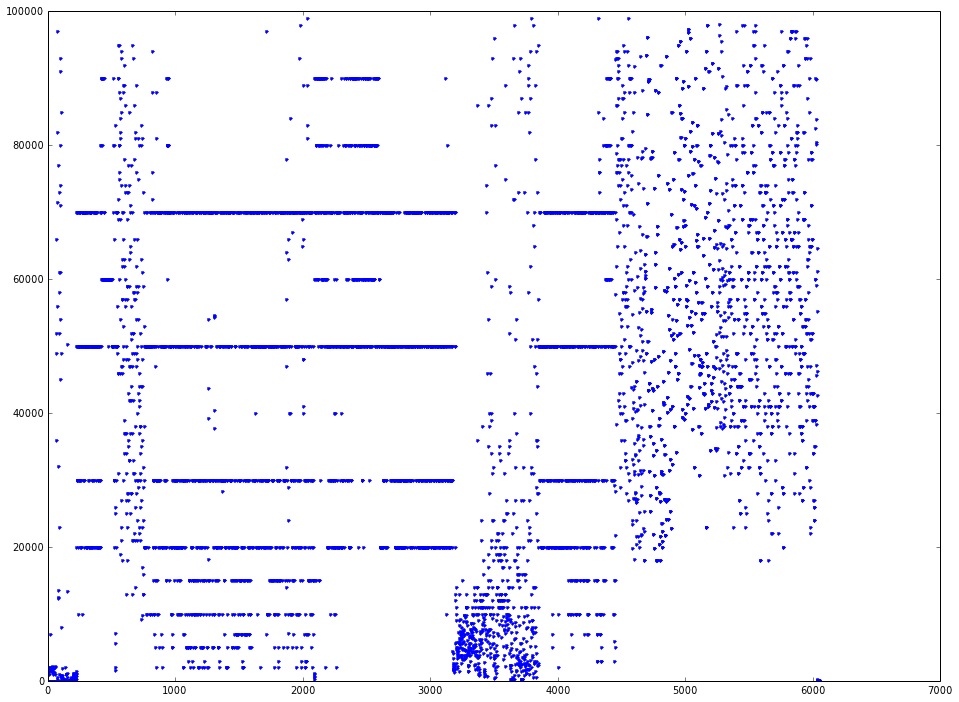

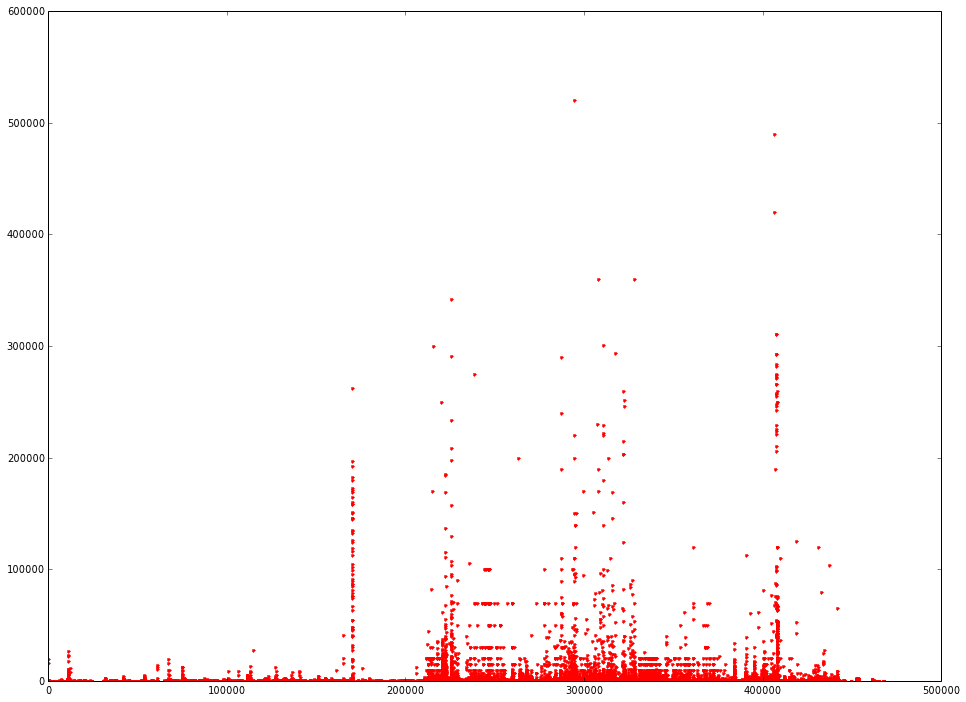

In [14]:
plotdata=chemdata[chemdata.TI < 100000][['TI']].values
#plotdata=chemdata['TI'].values

fig = plt.figure(figsize=(16,12),dpi=150)
plt.plot(plotdata,'b.')
plt.show()

plotdata=chemdata['CU'].values

fig = plt.figure(figsize=(16,12),dpi=150)
plt.plot(plotdata,'r.')
plt.show()

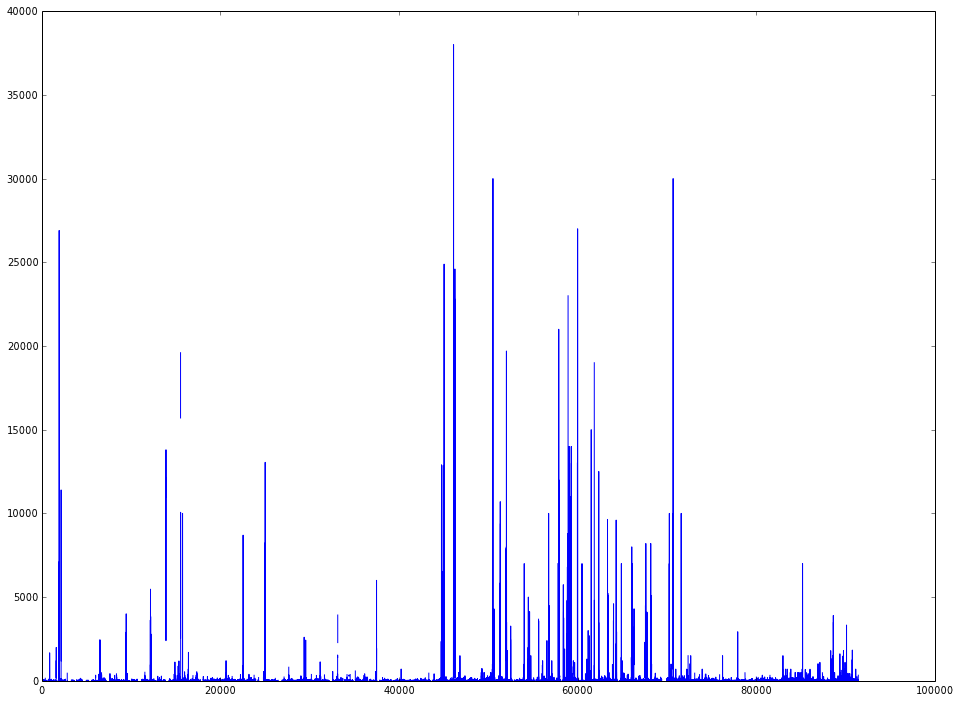

In [15]:
plotdata=chemdata[chemdata.SIO2 > 60][['CU']].values

fig = plt.figure(figsize=(16,12),dpi=150)

plt.plot(plotdata)
plt.show()

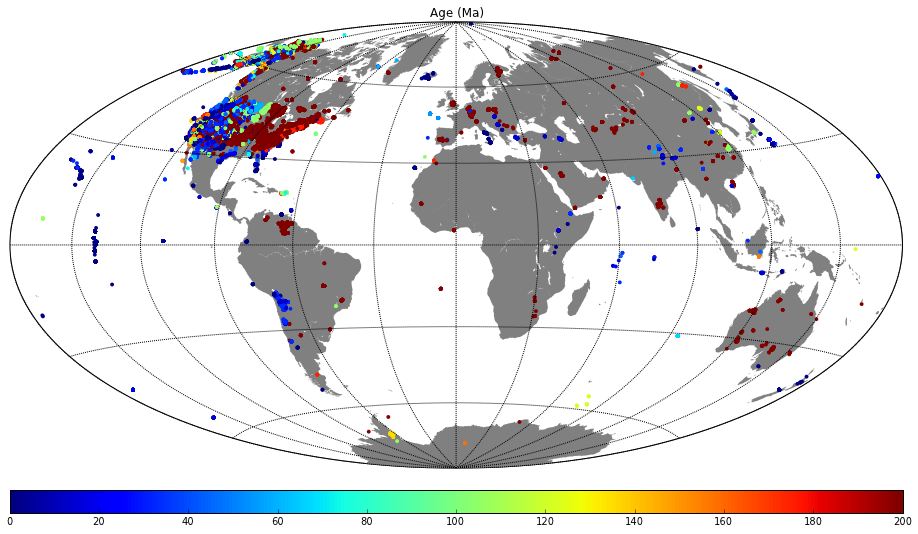

In [16]:
#Plot the EarthChem Data
lats=chemdata['LATITUDE'].values
longs=chemdata['LONGITUDE'].values
age=chemdata['AGE'].values

lats=chemdata[chemdata.TI < 10000000][['LATITUDE']].values
longs=chemdata[chemdata.TI < 10000000][['LONGITUDE']].values
age=chemdata[chemdata.TI < 10000000][['AGE']].values

fig = plt.figure(figsize=(16,12),dpi=150)

pmap = Basemap(projection='hammer', lat_0=0, lon_0=0,
           resolution='l')
pmap.drawmapboundary(fill_color='white')
pmap.fillcontinents(color='grey', lake_color='white', zorder=0)
pmap.drawmeridians(numpy.arange(0, 360, 30))
pmap.drawparallels(numpy.arange(-90, 90, 30))

xh, yh = pmap(longs, lats)
l1 = pmap.scatter(xh, yh, 15, marker='o', c=age,
              edgecolor='none', vmin=0, vmax=200)
pmap.colorbar(l1,location='bottom',pad="5%")
plt.title('Age (Ma)')
plt.show()

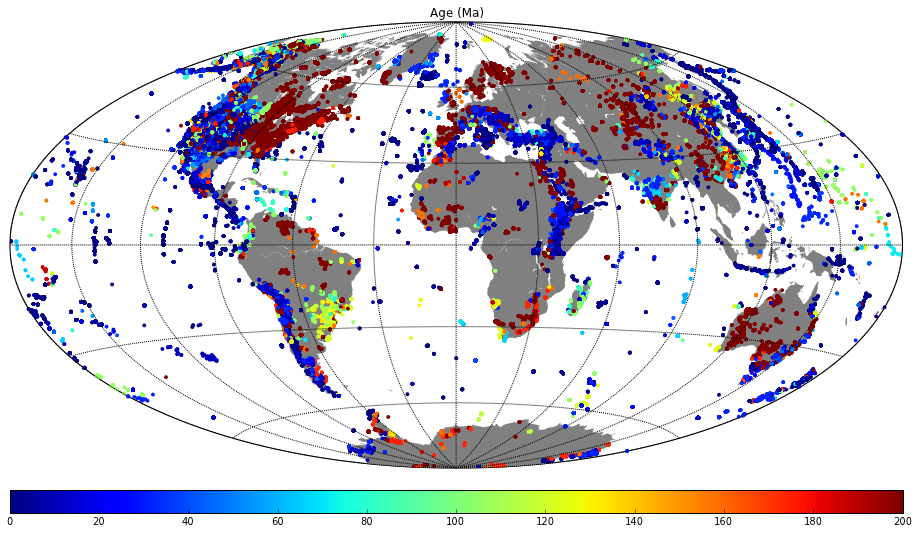

In [17]:
#Plot the EarthChem Data
lats=chemdata['LATITUDE'].values
longs=chemdata['LONGITUDE'].values
age=chemdata['AGE'].values

# lats=chemdata[chemdata.SIO2 > 60][['LATITUDE']].values
# longs=chemdata[chemdata.SIO2 > 60][['LONGITUDE']].values
# age=chemdata[chemdata.SIO2 > 60][['AGE']].values

fig = plt.figure(figsize=(16,12),dpi=150)

pmap = Basemap(projection='hammer', lat_0=0, lon_0=0,
           resolution='l')
pmap.drawmapboundary(fill_color='white')
pmap.fillcontinents(color='grey', lake_color='white', zorder=0)
pmap.drawmeridians(numpy.arange(0, 360, 30))
pmap.drawparallels(numpy.arange(-90, 90, 30))

xh, yh = pmap(longs, lats)
l1 = pmap.scatter(xh, yh, 15, marker='o', c=age,
              edgecolor='none', vmin=0, vmax=200)
pmap.colorbar(l1,location='bottom',pad="5%")
plt.title('Age (Ma)')
plt.show()

In [18]:
def readTopologyPlatepolygonFile(filename):
    '''
    Reads shapefiles and returns the all the data fields
    '''
    shapeRead = shapefile.Reader(filename)

    recs    = shapeRead.records()
    shapes  = shapeRead.shapes()
    fields  = shapeRead.fields
    Nshp    = len(shapes)
    
    return(recs,shapes,fields,Nshp)

In [19]:
#Load in all the Bertrand 2014 data

BertrandAsia="/Users/nbutter/Geodata/OREdeposits/XYBer14_t1_ASIA.shp"
BertrandAndes="/Users/nbutter/Geodata/OREdeposits/XYBer14_t2_ANDES.shp"

[ASIArecs,ASIAshapes,ASIAfields,ASIANshp]=readTopologyPlatepolygonFile(BertrandAsia)
[ANDESrecs,ANDESshapes,ANDESfields,ANDESshp]=readTopologyPlatepolygonFile(BertrandAndes)

BertrandData=[]

for nshpSub in xrange(ASIANshp):
    shapeArray=numpy.array(ASIAshapes[nshpSub].points)
    age=round(ASIArecs[nshpSub][6])
    BertrandData.append([shapeArray[0][0],shapeArray[0][1],age])
    
for nshpSub in xrange(ANDESshp):
    shapeArray=numpy.array(ANDESshapes[nshpSub].points)
    age=round(ANDESrecs[nshpSub][6])
    BertrandData.append([shapeArray[0][0],shapeArray[0][1],age])
    
BertrandData=numpy.array(BertrandData)

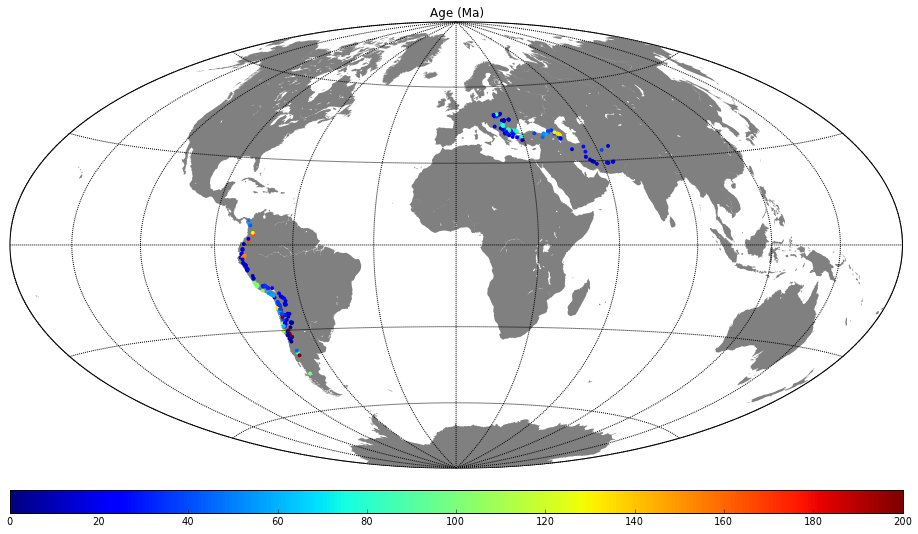

In [20]:
#Plot the Bertrand data

lats=BertrandData[:,1]
longs=BertrandData[:,0]
age=BertrandData[:,2]

fig = plt.figure(figsize=(16,12),dpi=150)

pmap = Basemap(projection='hammer', lat_0=0, lon_0=0,
           resolution='l')
pmap.drawmapboundary(fill_color='white')
pmap.fillcontinents(color='grey', lake_color='white', zorder=0)
pmap.drawmeridians(numpy.arange(0, 360, 30))
pmap.drawparallels(numpy.arange(-90, 90, 30))

xh, yh = pmap(longs, lats)
l1 = pmap.scatter(xh, yh, 15, marker='o', c=age,
              edgecolor='none', vmin=0, vmax=200)
pmap.colorbar(l1,location='bottom',pad="5%")
plt.title('Age (Ma)')
plt.show()

#Also load the Porcu Database

$$\epsilon=1$$

In [21]:
#Load in all the Porcu data (Singer, 2008), 
#which have been given numerical dates by Michael Rubey and Ben Dickonson

PorcuFile="/Users/nbutter/Geodata/OREdeposits/porcu/porcu_mrubey.shp"

[PORCUrecs,PORCUshapes,PORCUfields,PORCUshp]=readTopologyPlatepolygonFile(PorcuFile)

PorcuData=[]

for nshpSub in xrange(PORCUshp):
    shapeArray=numpy.array(PORCUshapes[nshpSub].points)
    age=round(PORCUrecs[nshpSub][10])
    PorcuData.append([shapeArray[0][0],shapeArray[0][1],age])

PorcuData=numpy.array(PorcuData)

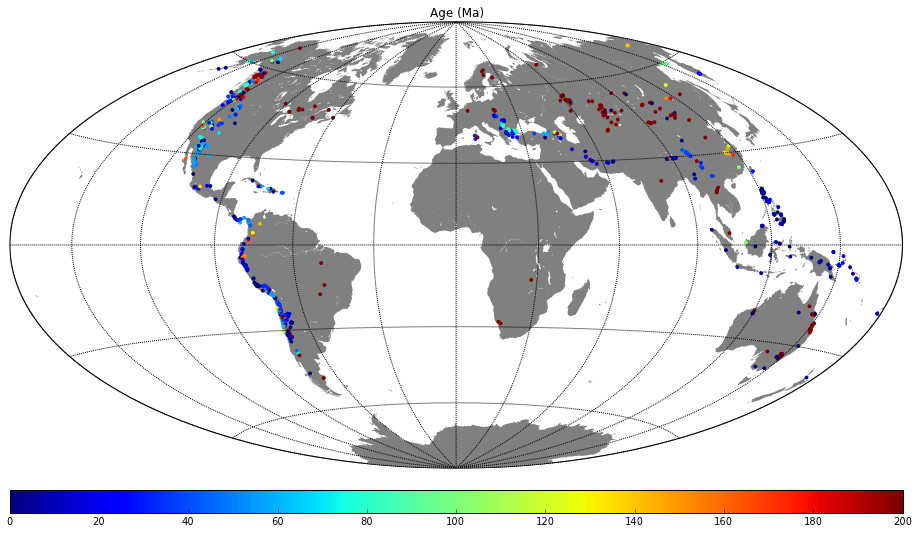

In [22]:
lats=PorcuData[:,1]
longs=PorcuData[:,0]
age=PorcuData[:,2]

fig = plt.figure(figsize=(16,12),dpi=150)

pmap = Basemap(projection='hammer', lat_0=0, lon_0=0,
           resolution='l')
pmap.drawmapboundary(fill_color='white')
pmap.fillcontinents(color='grey', lake_color='white', zorder=0)
pmap.drawmeridians(numpy.arange(0, 360, 30))
pmap.drawparallels(numpy.arange(-90, 90, 30))

xh, yh = pmap(longs, lats)
l1 = pmap.scatter(xh, yh, 15, marker='o', c=age,
              edgecolor='none', vmin=0, vmax=200)
pmap.colorbar(l1,location='bottom',pad="5%")
plt.title('Age (Ma)')
plt.show()